# Training U-Net for SAR water detection

In [1]:
import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import rasterio as rio
from rasterio.plot import show

## File locations

In [2]:
cwd = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/'
data_dir = '/Users/frape/Projects/DeepWetlands/Datasets/wetlands/'
images_dir = data_dir + 'sar/'
masks_dir = data_dir + 'ndwi_mask/'
tiles_data_file = data_dir + 'tiles.csv'

## Select GPU

In [3]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
    print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: mps


## Load dataset

In [4]:
tiles_data = pd.read_csv(tiles_data_file)
tiles_data.head(3)

,index,id,split
0,228,sala_kommun-228,train
1,229,sala_kommun-229,train
2,230,sala_kommun-230,train


## Visualize imagery and mask

(64, 64)


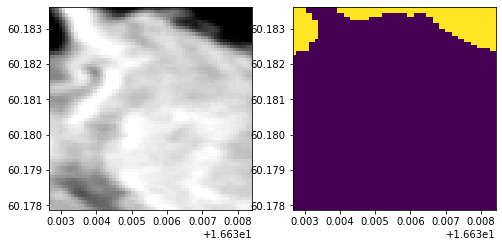

In [5]:
index = tiles_data.iloc[10]['id']
image_path = images_dir + str(index) + '-sar.tif'
mask_path = masks_dir + str(index) + '-ndwi_mask.tif'

# Open image file using Rasterio
sar_image = rio.open(image_path)
mask = rio.open(mask_path)


# fig, ax = plt.subplots(1, 2, figsize=(8,8)) 
# ax[0].imshow(image)
# ax[1].imshow(mask);



# Plot image and corresponding boundary
# fig, ax = plt.subplots(1, 2, figsize=(8,8))
# show(sar_image, ax=ax);
fig, ax = plt.subplots(1, 2, figsize=(8,8))
show(sar_image, ax=ax[0], cmap='gray')
show(mask, ax=ax[1])
# print(sar_image.count)
print(sar_image.read(1).shape)

## Create PyTorch DataLoader

In [6]:
class CFDDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        index_ = self.dataset.iloc[index]['id']

        # Get image and mask file paths for specified index
        image_path = images_dir + str(index_) + '-sar.tif'
        mask_path = masks_dir + str(index_) + '-ndwi_mask.tif'
        
        # Read image
        # image = plt.imread(image_path)
        image = rio.open(image_path).read()
        # print('former image shape', image.shape)
        # image = image.transpose((2, 1, 0))
        # print('new image shape', image.shape)
        
        # Read image
        # mask = plt.imread(mask_path)
        mask = rio.open(mask_path).read()
        # print('former mask shape', mask.shape)
        # mask = mask.transpose((1, 0))[None, :]
        # print('new mask shape', mask.shape)
        
        # Convert to Pytorch tensor
        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))
        
        return image_tensor, mask_tensor
    
    def __len__(self):
        return len(self.dataset)

In the following, we create a function for generating pytorch dataloaders. we use `torch`'s `DataLoader` class to create a dataloader.  The dataloader manages fetching samples from the datasets (it can even fetch them in parallel using `num_workers`) and assembles batches of the datasets. 

In [7]:
def get_dataloaders(data, batch_size):
    datasets = {
        'train' : CFDDataset(data[data.split == 'train']),
        'test' : CFDDataset(data[data.split == 'test'])
    }

    dataloaders = {
        'train': DataLoader(
          datasets['train'],
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers
        ),
        'test': DataLoader(
          datasets['test'],
          batch_size=batch_size,
          drop_last=False,
          num_workers=num_workers
        )
    }
    return dataloaders

## Visualize Wetlands Training Set

In [8]:
def visualize_batch(batch, batch_size):
    fig, ax = plt.subplots(2, 4, figsize=(batch_size*3, batch_size*1.5))

    for i in range(batch_size):
        image = batch[0][i].cpu().numpy()
        mask = batch[1][i].cpu().numpy()

        image = image.transpose((1, 2, 0))
        mask = mask.transpose((1, 2, 0)).squeeze()

        image = (image * 255.0).astype("uint8")
        mask = (mask * 255.0).astype("uint8")

        ax[0, i].imshow(image, cmap='gray')
        ax[1, i].imshow(mask)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Let's visualize a batch of 4 images as follows.

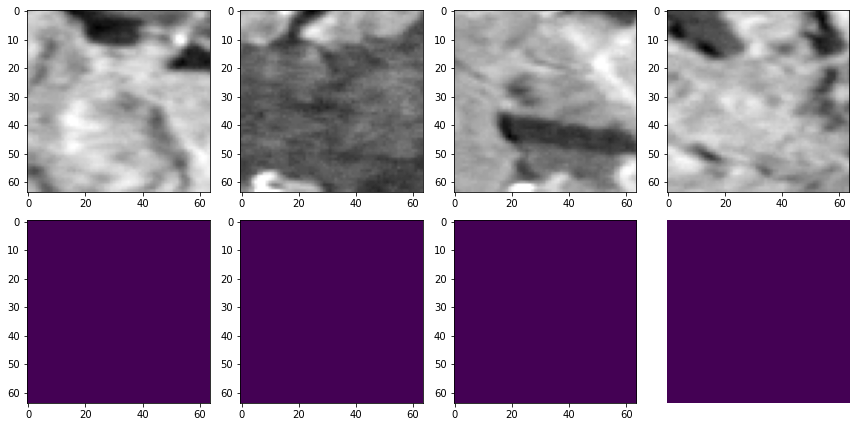

In [9]:
batch_size = 4
num_workers = 0
dataloaders = get_dataloaders(tiles_data, batch_size=batch_size)
train_batch = next(iter(dataloaders['train']))
visualize_batch(train_batch, batch_size)

## U-Net architecture

In [10]:
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32):
        super().__init__()

        self.encoder1 = self.block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.block(features, features*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.block(features*2, features*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.block(features*4, features*8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.block(features*8, features*16)

        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder4 = self.block(features*16, features*8)
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = self.block(features*8, features*4)
        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = self.block(features*4, features*2)
        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = self.block(features*2, features)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), dim=1))

        return torch.sigmoid(self.conv(dec1))

    def block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
      )

## Instantiate model

In [11]:
model = Unet(in_channels=1)
print(model)
input, target = next(iter(dataloaders['train']))
pred = model(input)
pred.shape

Unet(
  (encoder1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv2d(6

torch.Size([4, 1, 64, 64])

## Define loss function

In [12]:
class DiceLoss(nn.Module):
    def __init__(self, lambda_=1.):
        super(DiceLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, y_pred, y_true):
        y_pred = y_pred[:, 0].view(-1)
        y_true = y_true[:, 0].view(-1)
        intersection = (y_pred * y_true).sum()
        dice_loss = (2. * intersection  + self.lambda_) / (
            y_pred.sum() + y_true.sum() + self.lambda_
        )
        return 1. - dice_loss

## Training function

In [13]:
def train(model, dataloader, criterion, optimizer):
    model.train(True)  

    for input, target in tqdm(dataloader, total=len(dataloader)):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            output = model(input)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

    return loss

## Evaluation function

In [14]:
def evaluate(model, dataloader, criterion):
    model.eval()
    for input, target in tqdm(dataloader, total=len(dataloader)):
        input = input.to(device)
        target = target.to(device)

        with torch.set_grad_enabled(False):
            output = model(input)
            loss = criterion(output, target)
      
    return loss

## Hyperparameters

In [15]:
n_epochs = 15
learning_rate = 0.0001
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train and evaluate model

In [16]:
model.to(device)
for epoch in range(1, n_epochs + 1):    
    print("\nEpoch {}/{}".format(epoch, n_epochs))
    print("-" * 10)

    train_loss = train(
        model,
        dataloaders["train"],
        criterion,
        optimizer
    )
    val_loss = evaluate(
        model,
        dataloaders['test'],
        criterion
    )
    print('Train loss: {}, Val loss: {}'.format(
        train_loss.cpu().detach().numpy(), 
        val_loss.cpu().detach().numpy())
    )


Epoch 1/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.9997657537460327, Val loss: 0.9993007779121399

Epoch 2/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.9994866847991943, Val loss: 0.9992024302482605

Epoch 3/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.11082100868225098, Val loss: 0.9933999180793762

Epoch 4/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.8860737681388855, Val loss: 0.985848605632782

Epoch 5/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.9264652729034424, Val loss: 0.961800217628479

Epoch 6/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.0446513295173645, Val loss: 0.8465279340744019

Epoch 7/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.10803300142288208, Val loss: 0.05201447010040283

Epoch 8/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.027170419692993164, Val loss: 0.014580965042114258

Epoch 9/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.011147260665893555, Val loss: 0.004659414291381836

Epoch 10/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.11443358659744263, Val loss: 0.001890420913696289

Epoch 11/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.9949091672897339, Val loss: 0.0014445185661315918

Epoch 12/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.3271822929382324, Val loss: 0.0007745027542114258

Epoch 13/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.6668523550033569, Val loss: 0.0008047223091125488

Epoch 14/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.06092017889022827, Val loss: 0.0018385052680969238

Epoch 15/15
----------


  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

Train loss: 0.03200250864028931, Val loss: 0.00020498037338256836


## Save model

In [17]:
model_dir = cwd+"models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_file = model_dir + 'best_model_20220809.pth'
torch.save(model.state_dict(), model_file)
print('Model successfully saved to {}'.format(model_file))

Model successfully saved to /Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/models/best_model_20220809.pth


## Load model

In [18]:
# model_dir = "./drive/My Drive/Colab Notebooks/Crop Field Delineation/models/"
model_file = model_dir + 'best_model_20220809.pth'

loaded_model = Unet()
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file /Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/models/best_model_20220809.pth successfully loaded.


## Evaluate on a single image

(1, 64, 64)


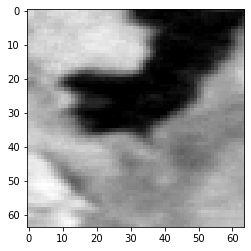

In [19]:
i = 120
model.eval()
index = tiles_data[tiles_data.split == 'test' ].iloc[i]['id']
image_path = images_dir + str(index) + '-sar.tif'
image = rio.open(image_path).read()
print(image.shape)
plt.imshow(image[0], cmap='gray');

(1, 1, 64, 64)


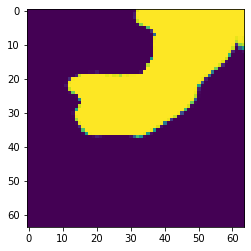

In [20]:
# image = image.transpose((2, 1, 0))[None, :]
image = image[None, :]
print(image.shape)
image = torch.from_numpy(image.astype(np.float32)).to(device)
pred = model(image).cpu().detach().numpy()
# pred = pred.squeeze().transpose((1, 0))
pred = pred.squeeze()
# pred = (pred * 255.0).astype("uint8")
plt.imshow(pred)

In [22]:
print(next(model.parameters()).device)
print(type(image), image.shape)
print(image)

mps:0
<class 'numpy.ndarray'> (1, 64, 64)
[[[0.91510934 0.91502416 0.92830014 ... 0.91978234 0.92353916 0.89737415]
  [0.9088544  0.91462815 0.9191577  ... 0.93771863 0.9573595  0.95184946]
  [0.8269024  0.85171807 0.8871823  ... 0.8787664  0.9273267  0.92859906]
  ...
  [0.8092563  0.83180475 0.8367226  ... 0.8586321  0.8596082  0.8534044 ]
  [0.8089256  0.82167304 0.82688326 ... 0.8375456  0.83144915 0.83067054]
  [0.8414871  0.8262737  0.8268389  ... 0.832076   0.8321568  0.8182023 ]]]


0


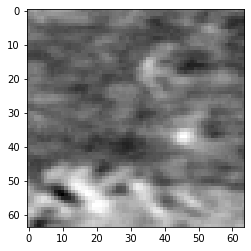

1


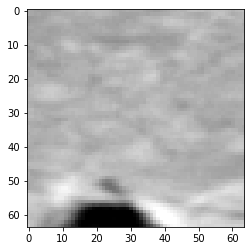

2


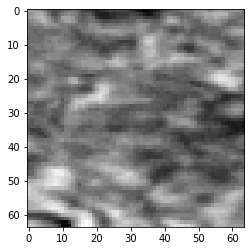

3


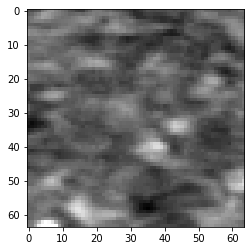

4


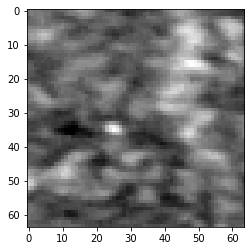

5


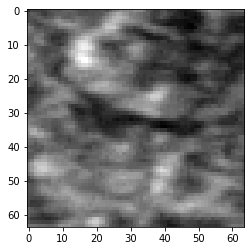

6


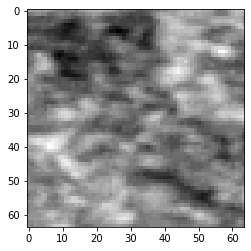

7


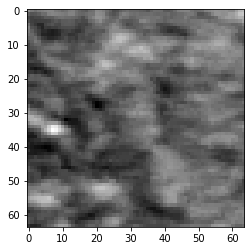

8


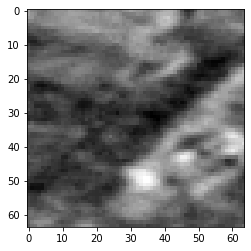

9


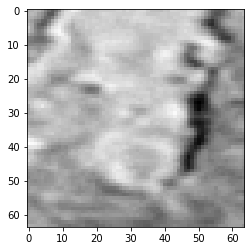

10


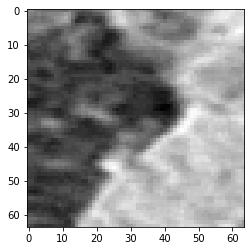

11


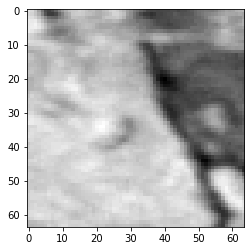

12


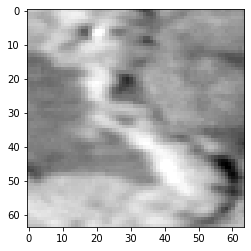

13


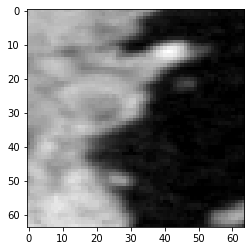

14


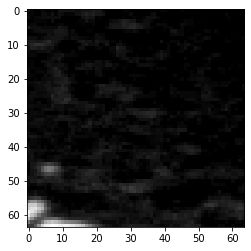

15


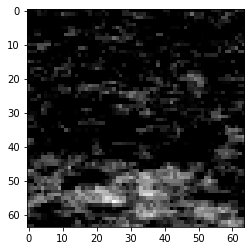

16


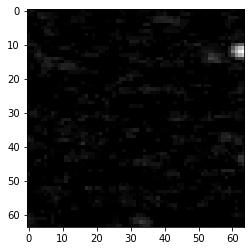

17


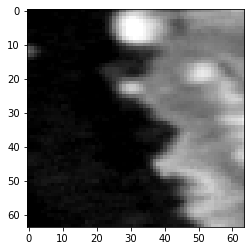

18


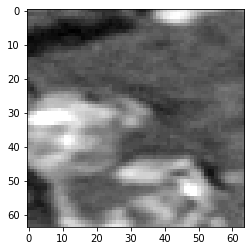

19


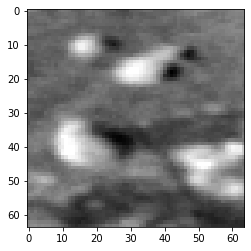

20


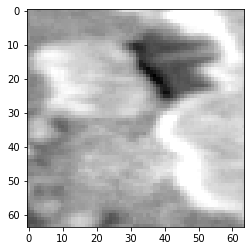

21


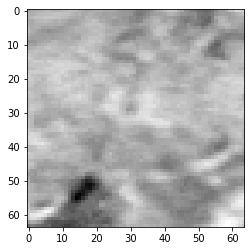

22


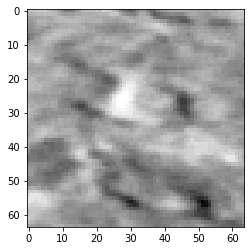

23


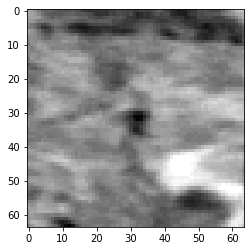

24


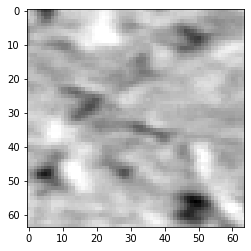

25


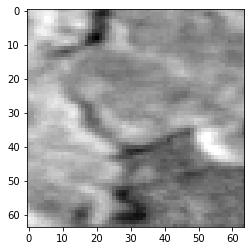

26


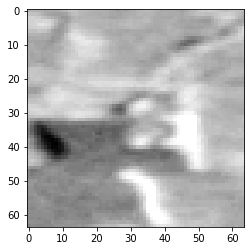

27


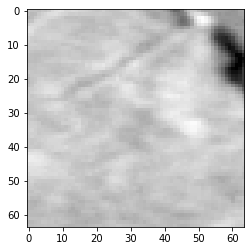

28


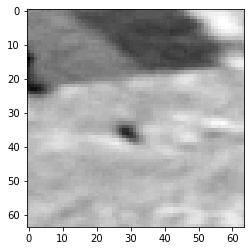

29


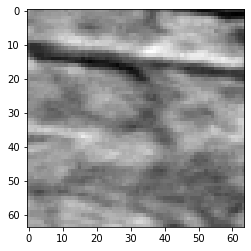

30


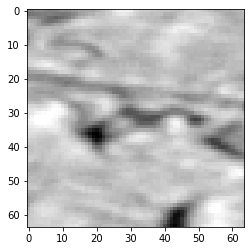

31


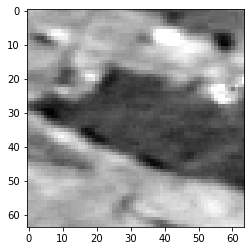

32


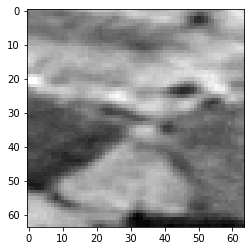

33


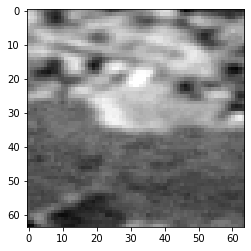

34


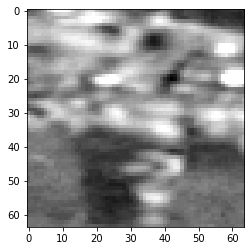

35


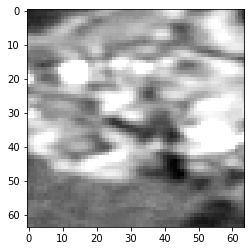

36


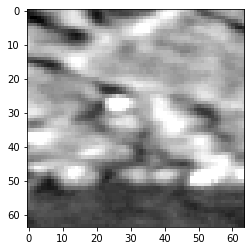

37


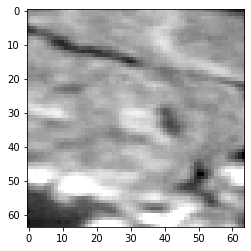

38


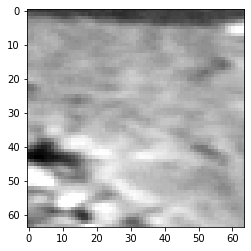

39


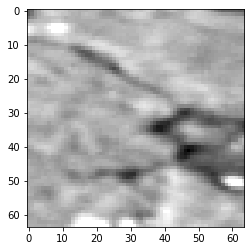

40


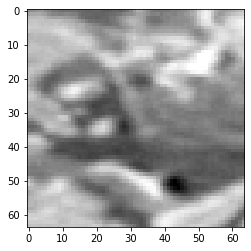

41


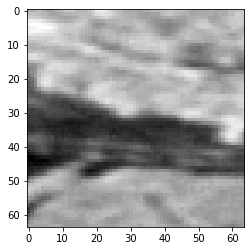

42


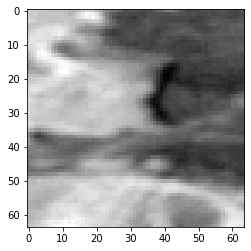

43


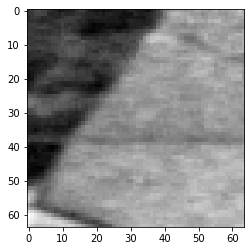

44


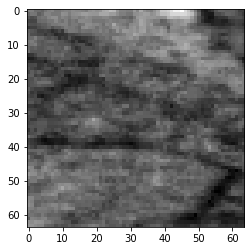

45


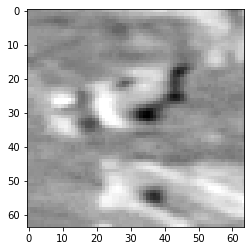

46


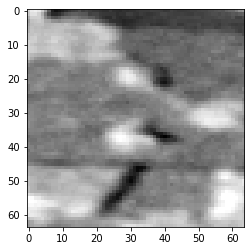

47


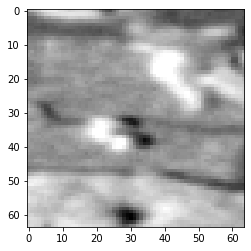

48


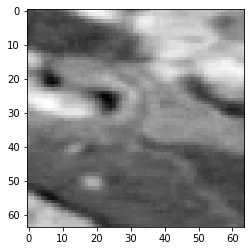

49


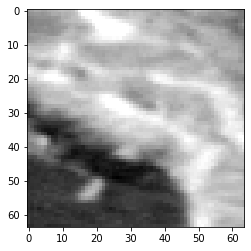

50


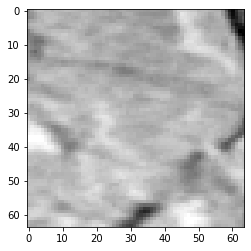

51


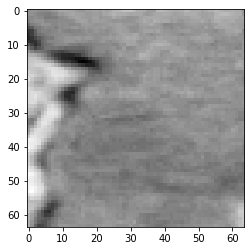

52


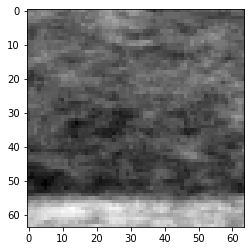

53


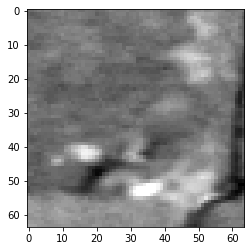

54


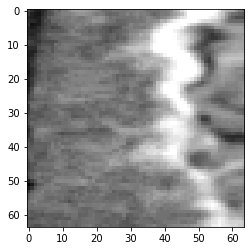

55


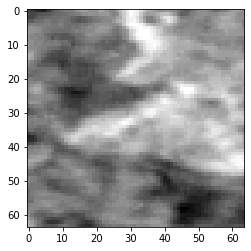

56


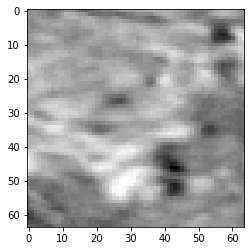

57


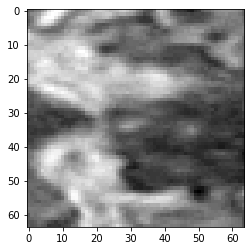

58


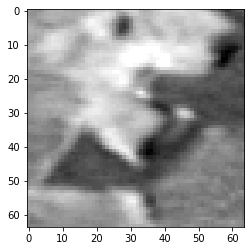

59


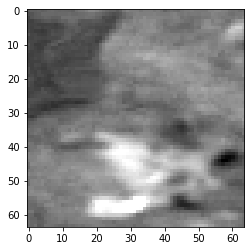

60


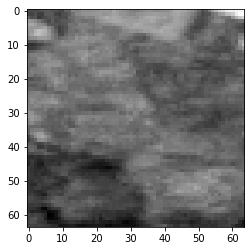

61


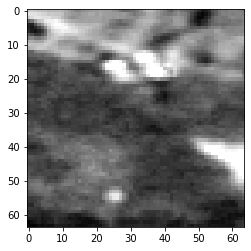

62


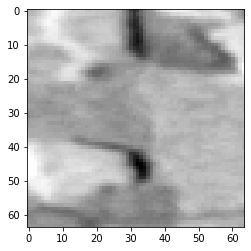

63


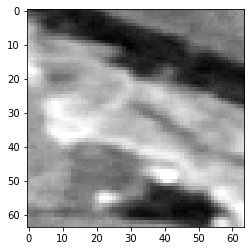

64


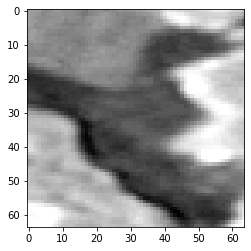

65


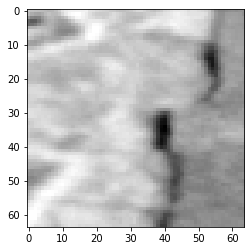

66


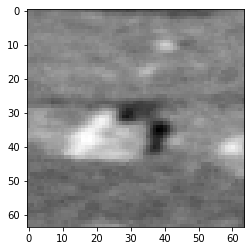

67


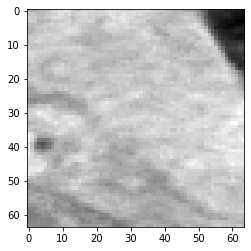

68


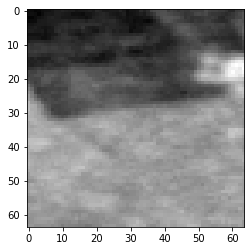

69


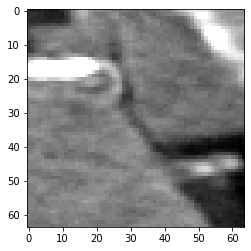

70


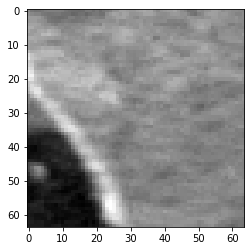

71


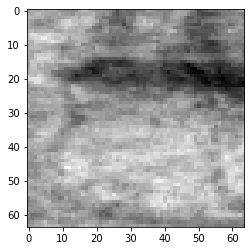

72


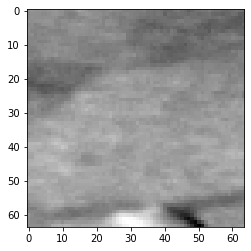

73


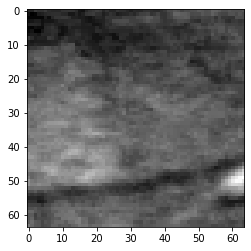

74


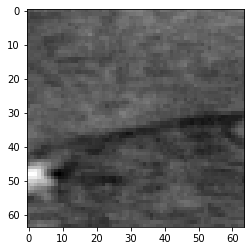

75


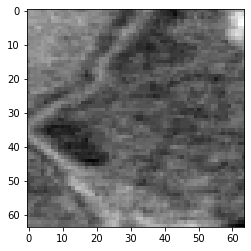

76


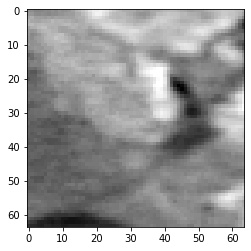

77


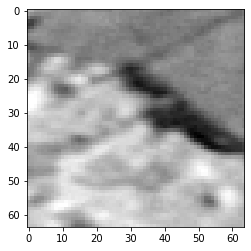

78


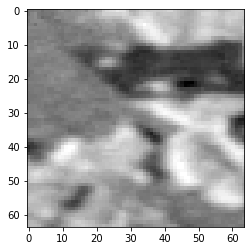

79


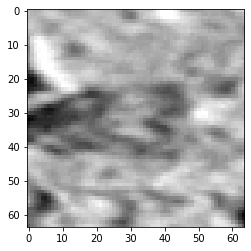

80


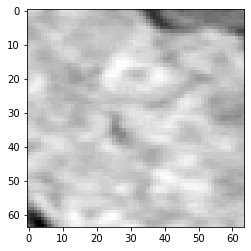

81


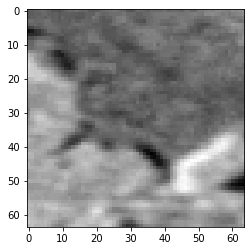

82


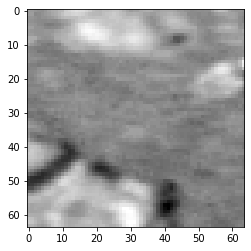

83


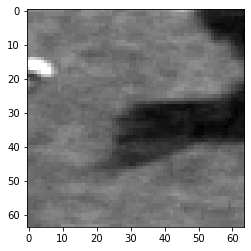

84


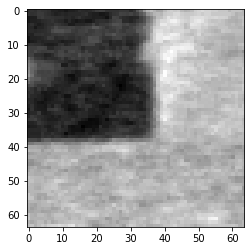

85


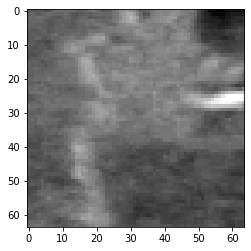

86


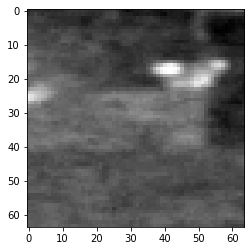

87


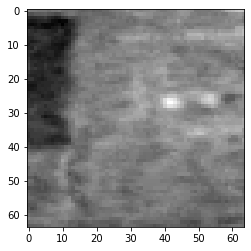

88


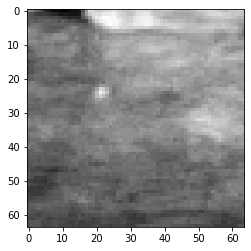

89


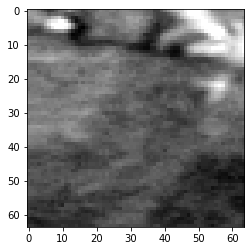

90


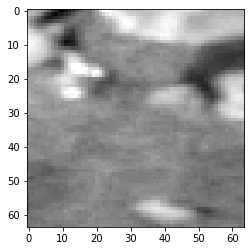

91


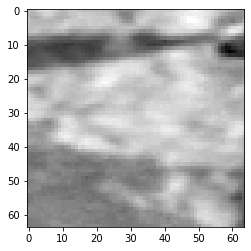

92


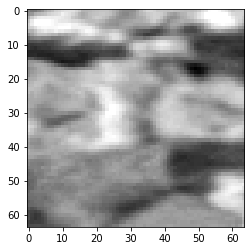

93


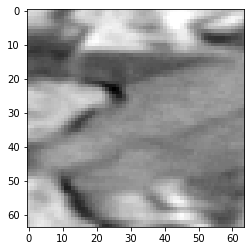

94


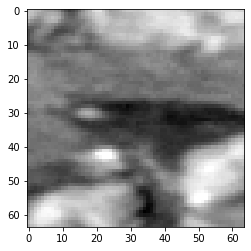

95


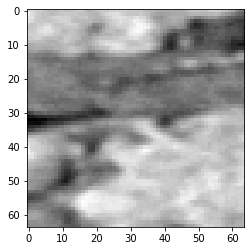

96


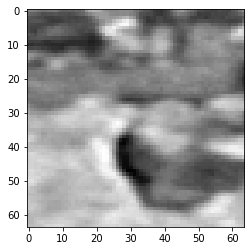

97


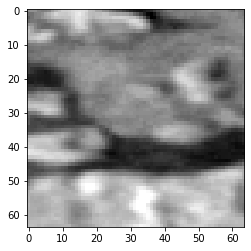

98


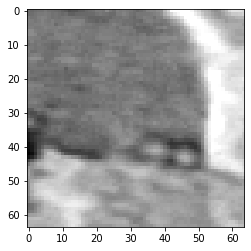

99


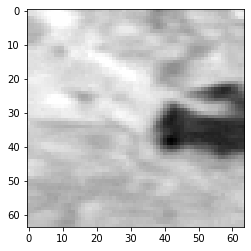

In [21]:
for i in range(100):
    # i = 690
    # model.eval()
    index = tiles_data[tiles_data.split == 'test' ].iloc[i]['id']
    image_path = images_dir + str(index) + '-sar.tif'
    image = rio.open(image_path).read()
    print(i)
    plt.imshow(image[0], cmap='gray');
    plt.show()